In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
#
import os
import numpy as np
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#
from sklearn.preprocessing import LabelEncoder
make_lb = LabelEncoder()
#
from sklearn.preprocessing import LabelBinarizer
lbb = LabelBinarizer()
#
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
#
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#
import pickle
#
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
# 
from sklearn.model_selection import GridSearchCV
#
from sklearn.linear_model import ElasticNetCV
#
from sklearn.linear_model import RidgeCV

---

## EDA

In [19]:
listings = pd.read_csv('listingscleanFINAL.csv')

In [20]:
listings.shape

(8059, 26)

In [21]:
listings.dropna(inplace=True)

In [22]:
listings.dropna(subset=['host_response_rate'], inplace=True)

In [23]:
listings.reset_index(drop=True, inplace=True)

In [24]:
listings['host_response_rate'] = listings['host_response_rate'].map(lambda x: x.replace('%', ''))
listings['price'] = listings['price'].map(lambda x: x.replace('$', ''))
listings['price'] = listings['price'].map(lambda x: x.replace(',', ''))

In [25]:
listings['price'] = listings['price'].astype('float')

In [26]:
# Refining the lists to only include valid prices
# For each type of response rate
prf_100 = []
for num in pr_100:
    if num > 0:
        prf_100.append(num)
prnf_100 = []
for num in prn_100:
    if num > 0:
        prnf_100.append(num)

NameError: name 'pr_100' is not defined

In [ ]:
# Two sample t test to see if the means are significantly different
stats.ttest_ind(prnf_100, prf_100, equal_var=True)

Cannot conclude that those who respond 100% of the time have higher prices than those who do not respond 100% of the time.

In [ ]:
listings = listings[['host_is_superhost', 'host_total_listings_count',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable']]

In [ ]:
listings.shape

----

### Final Cleaning and Analysis, Model Creation

In [27]:
listings2 = pd.read_csv('listingsclean2.csv')

In [28]:
listings2.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

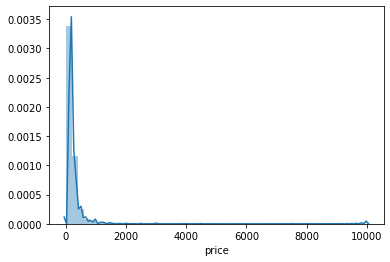

In [29]:
sns.distplot(listings2['price'])

In [ ]:
listings2['price'].describe()

In [30]:
listings2 = listings2[listings2['price'] <= 1000]

In [ ]:
listings2.isnull().sum()

In [ ]:
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(listings2.corr())
sns.heatmap(listings2.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

In [31]:
listings2 = listings2[listings2['minimum_nights'] < 59]

In [ ]:
listings2

In [ ]:
listings2.groupby('neighbourhood_cleansed')['price'].sum()

In [ ]:
rev = list(listings2.groupby('property_type')['price'].sum())
types = list(listings2.groupby('property_type')['price'].sum().keys())

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
chart = sns.barplot(x=types, y=rev)
chart.set_xticklabels(chart.get_xticklabels(),
                      rotation=45, horizontalalignment='right')

In [ ]:
listings2.price.sum()

In [ ]:
sns.distplot(listings2.price)

In [ ]:
(2818+1982+676+542)

In [ ]:
listings2.property_type.value_counts()

In [ ]:
props = list(listings2.property_type.value_counts().keys())
counts = list(listings2.property_type.value_counts())

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
chart2 = sns.barplot(x=props, y=counts)
plt.title('Count of Each Type of Property Type', fontsize=30)
chart2.set_xticklabels(chart2.get_xticklabels(),
                      rotation=45, horizontalalignment='right')

In [32]:
listings2_cut = listings2[(listings2['property_type'] == 'Apartment') | 
                         (listings2['property_type'] == 'House') | 
                         (listings2['property_type'] == 'Condominium') |
                         (listings2['property_type'] == 'Guest suite')]

In [ ]:
sns.distplot(listings2_cut.price)

Dropping most of the property types because we are looking for certain types of clients.

In [ ]:
listings2_cut.room_type.value_counts()

In [33]:
listings2_cut = listings2_cut[listings2_cut['room_type'] != 'Shared room']

In [13]:
listings2_cut.shape

(5859, 19)

In [39]:
listings2_cut

,host_response_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable
0,100,1,1.0,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1.0,1.0,2.0,170.0,2,25.0,1,217,97.000000,0
1,100,1,2.0,Inner Sunset,37.75402,-122.45805,House,Private room,2,1.0,1.0,1.0,99.0,2,20.0,1,160,94.000000,0
2,80,0,2.0,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1.0,2.0,3.0,235.0,2,0.0,30,111,98.000000,0
3,86,1,10.0,Haight Ashbury,37.76669,-122.45250,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,18,86.000000,0
4,86,1,10.0,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4.0,1.0,1.0,65.0,1,12.0,32,8,93.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108,75,0,4.0,Financial District,37.78879,-122.39321,Condominium,Entire home/apt,6,1.5,1.0,3.0,299.0,1,35.0,1,0,94.774194,1
7109,100,0,1.0,Downtown/Civic Center,37.78254,-122.41775,Apartment,Entire home/apt,3,1.0,2.0,2.0,100.0,1,0.0,50,0,90.798403,0
7110,100,0,0.0,Mission,37.75994,-122.41180,Apartment,Entire home/apt,4,1.0,0.0,1.0,250.0,1,0.0,2,0,96.132800,1
7111,100,0,9.0,Downtown/Civic Center,37.77799,-122.42159,Condominium,Entire home/apt,4,1.0,1.0,2.0,200.0,1,0.0,1,0,90.798403,1


In [34]:
room = pd.get_dummies(listings2_cut['room_type'], prefix='room', drop_first=True)
nbrhd = pd.get_dummies(listings2_cut['neighbourhood_cleansed'], prefix='nbrhd', drop_first=True)
prop = pd.get_dummies(listings2_cut['property_type'], prefix='prop', drop_first=True)


In [35]:
listings2_cut.drop(columns=['room_type', 'neighbourhood_cleansed', 'property_type'], axis=1, inplace=True)

In [36]:
list_working = pd.concat([listings2_cut, room, nbrhd, prop], axis=1)

In [44]:
list_working.shape

(5859, 55)

In [45]:
list_working.to_csv('list_working.csv')

In [46]:
list_working.head()

,host_response_rate,host_is_superhost,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,nbrhd_Russian Hill,nbrhd_Seacliff,nbrhd_South of Market,nbrhd_Twin Peaks,nbrhd_Visitacion Valley,nbrhd_West of Twin Peaks,nbrhd_Western Addition,prop_Condominium,prop_Guest suite,prop_House
0,100,1,1.0,37.76931,-122.43386,3,1.0,1.0,2.0,170.0,...,0,0,0,0,0,0,1,0,0,0
1,100,1,2.0,37.75402,-122.45805,2,1.0,1.0,1.0,99.0,...,0,0,0,0,0,0,0,0,0,1
2,80,0,2.0,37.74511,-122.42102,5,1.0,2.0,3.0,235.0,...,0,0,0,0,0,0,0,0,0,0
3,86,1,10.0,37.76669,-122.45250,2,4.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,0
4,86,1,10.0,37.76487,-122.45183,2,4.0,1.0,1.0,65.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
target = list_working.price
data = list_working.drop(columns='price', axis=1)

In [38]:
def make_models(data, target, num_iter=5, models=['ols', 'lasso', 'ridge'],
               alpha=10, complexity='simple', degree=3):
    x_axis = np.arange(num_iter)
    ols_test = []
    lasso_test = []
    ridge_test = []
    sample_models = {}
    model_metrics = {}
    
    for i in range(num_iter):
        if complexity == 'simple':
            X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)
        elif complexity == 'polynomial':
            poly = PolynomialFeatures(degree=degree)
            Xp = poly.fit_transform(data)
            X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
        elif complexity == 'poly_intx':
            poly_intx = PolynomialFeatures(degree=degree, interaction_only=True)
            Xpn = poly_intx.fit_transform(data)
            X_train, X_test, Y_train, Y_test = train_test_split(Xpn, target, test_size=0.2)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train=scaler.transform(X_train)
        X_test=scaler.transform(X_test)
        
        if 'ols' in models:
            linreg = LinearRegression()
            ols_model_tr = linreg.fit(X_train, Y_train)
            train_pred = ols_model_tr.predict(X_train)
            test_pred = ols_model_tr.predict(X_test)
            
            sample_models['ols'] = ols_model_tr
            
            test_score = ols_model_tr.score(X_test, Y_test)
            ols_test.append(test_score)
            
            model_metrics['ols_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['ols_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['ols_test_r2'] = ols_model_tr.score(X_test, Y_test)
            model_metrics['ols_train_r2'] = ols_model_tr.score(X_train, Y_train)
        
        if 'lasso' in models:
            lasso = Lasso(alpha=alpha, max_iter=1000, normalize=True)
            lasso_model_tr = lasso.fit(X_train, Y_train)
            train_pred = lasso_model_tr.predict(X_train)
            test_pred = lasso_model_tr.predict(X_test)
            sample_models['lasso'] = lasso_model_tr
            test_score = lasso_model_tr.score(X_test, Y_test)
            lasso_test.append(test_score)
            model_metrics['lasso_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['lasso_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['lasso_test_r2'] = lasso_model_tr.score(X_test, Y_test)
            model_metrics['lasso_train_r2'] = lasso_model_tr.score(X_train, Y_train)
        if 'ridge' in models:
            ridge = Ridge(alpha=alpha, max_iter=1000, normalize=True)
            ridge_model_tr = ridge.fit(X_train, Y_train)
            train_pred = ridge_model_tr.predict(X_train)
            test_pred = ridge_model_tr.predict(X_test)
            sample_models['ridge'] = ridge_model_tr
            test_score = ridge_model_tr.score(X_test, Y_test)
            ridge_test.append(test_score)
            model_metrics['ridge_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
            model_metrics['ridge_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
            model_metrics['ridge_test_r2'] = ridge_model_tr.score(X_test, Y_test)
            model_metrics['ridge_train_r2'] = ridge_model_tr.score(X_train, Y_train)
        i += 1
    
    if 'ols' in models:
        plt.plot(ols_test, label='ols')
    if 'ridge' in models:
        plt.plot(ridge_test, label='ridge')
    if 'lasso' in models:
        plt.plot(lasso_test, label='lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    plt.ylim((0.40, 0.99))

    plt.legend()
    
    
                              
    return sample_models, model_metrics
        
        
        
        
        
        

({'ols': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
  'lasso': Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
        positive=False, precompute=False, random_state=None, selection='cyclic',
        tol=0.0001, warm_start=False),
  'ridge': Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
        random_state=None, solver='auto', tol=0.001)},
 {'ols_train_rmse': 90.77235766590681,
  'ols_test_rmse': 97.55923714248738,
  'ols_test_r2': 0.5739225928968581,
  'ols_train_r2': 0.5872853752344973,
  'lasso_train_rmse': 141.2956157556655,
  'lasso_test_rmse': 149.49425024055924,
  'lasso_test_r2': -0.00046222081120861347,
  'lasso_train_r2': 0.0,
  'ridge_train_rmse': 124.30523495479389,
  'ridge_test_rmse': 132.5202300246809,
  'ridge_test_r2': 0.21383070672292637,
  'ridge_train_r2': 0.22603474482841657})

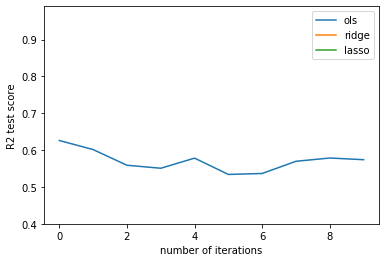

In [39]:
make_models(data, target, num_iter=10, models=['ols', 'lasso', 'ridge'],
               alpha=10, complexity='simple', degree=2)

---

### Feature Selection Run

In [50]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [53]:
data.shape

(5859, 54)

In [51]:
stepwise_selection(data, target, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is dep

Add  beds                           with p-value 0.0
Add  bedrooms                       with p-value 1.91757e-138
Add  room_Private room              with p-value 4.96209e-125
Add  minimum_nights                 with p-value 1.14304e-100
Add  latitude                       with p-value 1.21775e-91
Add  number_of_reviews              with p-value 4.11729e-37
Add  bathrooms                      with p-value 1.11899e-29
Add  extra_people                   with p-value 4.12856e-19
Add  accommodates                   with p-value 1.18912e-18
Drop beds                           with p-value 0.260428


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Add  longitude                      with p-value 8.24926e-12
Add  review_scores_rating           with p-value 1.02178e-10
Add  prop_Guest suite               with p-value 1.86525e-08
Add  nbrhd_Pacific Heights          with p-value 3.30435e-08
Add  nbrhd_Nob Hill                 with p-value 1.5447e-05
Add  nbrhd_Chinatown                with p-value 1.1252e-05
Add  nbrhd_Noe Valley               with p-value 3.33001e-05
Add  nbrhd_Outer Richmond           with p-value 7.62525e-05
Add  nbrhd_Castro/Upper Market      with p-value 0.000229358
Add  nbrhd_South of Market          with p-value 0.000254826
Add  nbrhd_Outer Sunset             with p-value 0.000168641
Drop longitude                      with p-value 0.138088
Add  host_response_rate             with p-value 0.000401825
Add  prop_House                     with p-value 0.000711608
Add  nbrhd_Inner Richmond           with p-value 0.00111427
Add  nbrhd_Parkside                 with p-value 0.000975954
Add  nbrhd_Excelsior          

['bedrooms',
 'room_Private room',
 'minimum_nights',
 'latitude',
 'number_of_reviews',
 'bathrooms',
 'extra_people',
 'accommodates',
 'review_scores_rating',
 'prop_Guest suite',
 'nbrhd_Pacific Heights',
 'nbrhd_Nob Hill',
 'nbrhd_Chinatown',
 'nbrhd_Noe Valley',
 'nbrhd_Outer Richmond',
 'nbrhd_Castro/Upper Market',
 'nbrhd_South of Market',
 'nbrhd_Outer Sunset',
 'host_response_rate',
 'prop_House',
 'nbrhd_Inner Richmond',
 'nbrhd_Parkside',
 'nbrhd_Excelsior',
 'guests_included',
 'nbrhd_Seacliff',
 'prop_Condominium',
 'nbrhd_Financial District']

In [76]:
data2 = data[['bedrooms',
 'room_Private room',
 'minimum_nights',
 'latitude',
 'number_of_reviews',
 'bathrooms',
 'extra_people',
 'accommodates',
 'review_scores_rating',
 'prop_Guest suite',
 'nbrhd_Pacific Heights',
 'nbrhd_Nob Hill',
 'nbrhd_Chinatown',
 'nbrhd_Noe Valley',
 'nbrhd_Outer Richmond',
 'nbrhd_Castro/Upper Market',
 'nbrhd_South of Market',
 'nbrhd_Outer Sunset',
 'host_response_rate',
 'prop_House',
 'nbrhd_Inner Richmond',
 'nbrhd_Parkside',
 'nbrhd_Excelsior',
 'guests_included',
 'nbrhd_Seacliff',
 'prop_Condominium',
 'nbrhd_Financial District']]

#### Trying out different models with the reduced predictor dataset

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12180.379794169217, tolerance: 9841.950945210156
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11960.118356157094, tolerance: 9566.725960273096
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13020.9237472713, tolerance: 9530.557443268617
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap:

({'lasso': Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=True, positive=False, precompute=False, random_state=None,
        selection='cyclic', tol=0.0001, warm_start=False),
  'ridge': Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=True, random_state=None, solver='auto', tol=0.001)},
 {'lasso_train_rmse': 83.48769685803639,
  'lasso_test_rmse': 87.9015223702678,
  'lasso_test_r2': 0.6277471115051148,
  'lasso_train_r2': 0.6576286427382395,
  'ridge_train_rmse': 76.38201039655657,
  'ridge_test_rmse': 94.30375700398784,
  'ridge_test_r2': 0.5715469160704405,
  'ridge_train_r2': 0.7134274201704972})

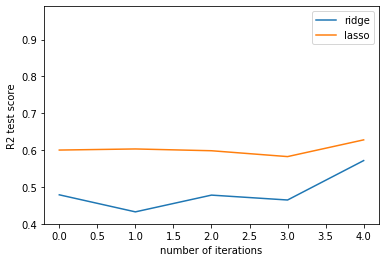

In [62]:
make_models(data2, target, num_iter=5, models=['lasso', 'ridge'],
               alpha=0.01, complexity='poly_intx', degree=3)

---

#### Refactoring the `make_models` function to include `LassoCV`, `RidgeCV`, `ElasticNetCV` instead of using `GridSearchCV` for model selection and hyperparameter tuning. These three functions also seem to be computationally more efficient.

In [101]:
def make_models(data, target, num_iter=5, models=['ols', 'lasso', 'ridge', 'enet'],
                complexity='simple', degree=3):
    x_axis = np.arange(num_iter)
    ols_test = []
    lasso_test = []
    ridge_test = []
    enet_test = []
    a_parms=[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]
    l1_parms = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
    cv_param=[3, 5, 8, 10]
    sample_models = {}
    model_metrics = {}
    


    for val in cv_param:
                for i in range(num_iter):
                    if complexity == 'simple':
                        X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.2)
                    elif complexity == 'polynomial':
                        poly = PolynomialFeatures(degree=degree)
                        Xp = poly.fit_transform(data)
                        X_train, X_test, Y_train, Y_test = train_test_split(Xp, target, test_size=0.2)
                    elif complexity == 'poly_intx':
                        poly_intx = PolynomialFeatures(degree=degree, interaction_only=True)
                        Xpn = poly_intx.fit_transform(data)
                        X_train, X_test, Y_train, Y_test = train_test_split(Xpn, target, test_size=0.2)
                    scaler = StandardScaler()
                    scaler.fit(X_train)
                    X_train=scaler.transform(X_train)
                    X_test=scaler.transform(X_test)
                    
                    if 'ols' in models:
                        linreg = LinearRegression()
                        ols_model_tr = linreg.fit(X_train, Y_train)
                        train_pred = ols_model_tr.predict(X_train)
                        test_pred = ols_model_tr.predict(X_test)
                        sample_models['ols'] = ols_model_tr
                        test_score = ols_model_tr.score(X_test, Y_test)
                        ols_test.append(test_score)
                        model_metrics['ols_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['ols_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['ols_test_r2'] = ols_model_tr.score(X_test, Y_test)
                        model_metrics['ols_train_r2'] = ols_model_tr.score(X_train, Y_train)
                    
                    if 'lasso' in models:
                        lasso = LassoCV(alphas=a_parms, normalize=True, cv=val)
                        lasso_model_tr = lasso.fit(X_train, Y_train)
                        train_pred = lasso_model_tr.predict(X_train)
                        test_pred = lasso_model_tr.predict(X_test)
                        sample_models['lasso'] = lasso_model_tr
                        test_score = lasso_model_tr.score(X_test, Y_test)
                        lasso_test.append(test_score)
                        model_metrics['lasso_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['lasso_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['lasso_test_r2'] = lasso_model_tr.score(X_test, Y_test)
                        model_metrics['lasso_train_r2'] = lasso_model_tr.score(X_train, Y_train)

                    if 'ridge' in models:
                        ridge = RidgeCV(alphas=a_parms, normalize=True, cv=val)
                        ridge_model_tr = ridge.fit(X_train, Y_train)
                        train_pred = ridge_model_tr.predict(X_train)
                        test_pred = ridge_model_tr.predict(X_test)
                        sample_models['ridge'] = ridge_model_tr
                        test_score = ridge_model_tr.score(X_test, Y_test)
                        ridge_test.append(test_score)
                        model_metrics['ridge_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['ridge_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['ridge_test_r2'] = ridge_model_tr.score(X_test, Y_test)
                        model_metrics['ridge_train_r2'] = ridge_model_tr.score(X_train, Y_train)

                    if 'enet' in models:
                        enet = ElasticNetCV(alphas=a_parms, l1_ratio = l1_parms, cv=val)
                        enet_model_tr = enet.fit(X_train, Y_train)
                        train_pred = enet_model_tr.predict(X_train)
                        test_pred = enet_model_tr.predict(X_test)
                        sample_models['enet'] = enet_model_tr
                        test_score = enet_model_tr.score(X_test, Y_test)
                        enet_test.append(test_score)
                        model_metrics['enet_train_rmse'] = np.sqrt(mean_squared_error(Y_train, train_pred))
                        model_metrics['enet_test_rmse'] = np.sqrt(mean_squared_error(Y_test, test_pred))
                        model_metrics['enet_test_r2'] = enet_model_tr.score(X_test, Y_test)
                        model_metrics['enet_train_r2'] = enet_model_tr.score(X_train, Y_train)
                    i += 1
    
    if 'ols' in models:
        plt.plot(ols_test, label='ols')
    if 'ridge' in models:
        plt.plot(ridge_test, label='ridge')
    if 'lasso' in models:
        plt.plot(lasso_test, label='lasso')
    plt.ylabel('R2 test score')
    plt.xlabel('number of iterations')
    plt.ylim((0.40, 0.99))

    plt.legend()
    
    model_metrics =  pd.DataFrame(model_metrics.items())
    
    
                              
    return sample_models, model_metrics

In [ ]:
make_models(data=data, num_iter=15, target=target, models=['ols', 'lasso', 'ridge', 'enet'])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225107.06974159926, tolerance: 6499.047999615878
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5748301.7069240175, tolerance: 6499.047999615878
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134508.16357927024, tolerance: 6571.0432171520015
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 379615.9946754351, tolerance: 6571.0432171520015
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12908392.720257817, tolerance: 6571.0432171520015
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366653.917739816, tolerance: 6193.545407232001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12401466.312010387, tolerance: 6225.897699968
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1227556.4830406606, tolerance: 6169.970100224071
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11427627.259601204, tolerance: 6169.970100224071
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12212713.379380327, tolerance: 6531.40383543534
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 233955.73092167452, tolerance: 6531.40383543534
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13887428.341631025, tolerance: 6531.40383543534
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160213.90904328972, tolerance: 6368.008925248
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12378141.58410352, tolerance: 6368.008925248
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345892.85105806217, tolerance: 6531.40383543534
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11964592.958807701, tolerance: 6068.073214528001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776897.3654663153, tolerance: 6459.654302208
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11447449.177591713, tolerance: 6459.654302208
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 452501.8651389852, tolerance: 6051.9854828105
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11111093.149952885, tolerance: 6051.9854828105
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511371.5487971604, tolerance: 6272.450191552
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12650980.495259548, tolerance: 6735.913578585149
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 234472.9923733212, tolerance: 6735.913578585149
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14077635.74396165, tolerance: 6735.913578585149
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11272058.753197137, tolerance: 6735.913578585149
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 291080.2388011329, tolerance: 6410.140633408
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12185338.745665196, tolerance: 6410.140633408
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 471849.33725440875, tolerance: 6320.33701574904
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12197239.873102693, tolerance: 6320.33701574904
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 224012.9325055778, tolerance: 6407.210695168001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12301728.295694025, tolerance: 7060.430849519847
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242637.73244042322, tolerance: 7060.430849519847
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13770201.126179343, tolerance: 7060.430849519847
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101554.57316939533, tolerance: 6147.3921408000015
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11048681.776077675, tolerance: 6147.3921408000015
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 346608.7522224374, tolerance: 6581.459470912002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12948524.811187575, tolerance: 6417.006996352001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1711407.282084981, tolerance: 6140.1319791999995
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12336958.136882847, tolerance: 6140.1319791999995
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12376591.67268981, tolerance: 6785.962010083229
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212200.32177706808, tolerance: 6785.962010083229
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13975691.935374271, tolerance: 6785.962010083229
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 377001.3859697655, tolerance: 6785.962010083229
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12547609.063482666, tolerance: 6785.962010083229
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29926.338411498815, tolerance: 6155.673620608
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214255.2872110866, tolerance: 6609.148425472001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11719094.19181647, tolerance: 6609.148425472001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26761.02195134014, tolerance: 6321.896364800001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7919.612276010215, tolerance: 6400.8287232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12131405.091521304, tolerance: 6400.8287232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 115090.57406570017, tolerance: 6397.126299199743
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338460.64303326607, tolerance: 6400.8287232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11163952.355783688, tolerance: 6400.8287232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66529.3282526955, tolerance: 6421.955820326504
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to inc

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83101.7620687969, tolerance: 6421.955820326504
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12254692.095572764, tolerance: 6421.955820326504
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74684.59856213629, tolerance: 6323.04892
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to i

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 845105.5378331318, tolerance: 6333.998586267606
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11558938.117647555, tolerance: 6333.998586267606
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 573602.6279105358, tolerance: 6320.091955648001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11217774.488723975, tolerance: 6536.762392925737
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164966.71641510352, tolerance: 6536.762392925737
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12947143.364003604, tolerance: 6536.762392925737
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338210.49189903215, tolerance: 6536.762392925737
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12566073.10302925, tolerance: 6536.762392925737
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 169742.2537965253, tolerance: 6813.971480000001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15130180.36330996, tolerance: 7542.063979973334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2889633.1502781436, tolerance: 7536.836223573332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15271549.187396595, tolerance: 7536.836223573332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13390977.536318855, tolerance: 7542.063979973334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 280813.4833035469, tolerance: 7536.836223573332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14634340.006975489, tolerance: 7536.836223573332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10259759.60477191, tolerance: 7774.3242126433715
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28935.947129175067, tolerance: 7774.3242126433715
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13839051.031525835, tolerance: 7852.1167519338505
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1008891.8295391388, tolerance: 7880.411786773333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16100842.309308017, tolerance: 7880.411786773333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168297.7370860353, tolerance: 7686.741536463055
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4849936.360906642, tolerance: 7686.741536463055
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 222763.9543503821, tolerance: 7501.056704561216
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15342620.478518182, tolerance: 7579.793973440001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2551879.3737038225, tolerance: 7657.864709333334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15152831.642088115, tolerance: 7657.864709333334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14042347.045062039, tolerance: 7579.793973440001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253462.63035025075, tolerance: 7657.864709333334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15118308.928185541, tolerance: 7657.864709333334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4076182.052681977, tolerance: 7415.821996852496
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14878262.741228553, tolerance: 7415.821996852496
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12377234.723620106, tolerance: 7760.356225660175
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1294361.999742046, tolerance: 7996.122444693332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14436224.949520778, tolerance: 7996.122444693332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 825489.8067143671, tolerance: 7787.282806
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15540118.811808951, tolerance: 7787.282806
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163904.26013902575, tolerance: 7869.220843318219
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4881198.65075212, tolerance: 7869.220843318219
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4552066.383401176, tolerance: 7816.833189333335
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16263305.993224623, tolerance: 7816.833189333335
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3164726.2204989456, tolerance: 7930.331081173335
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301033.9922141172, tolerance: 7816.833189333335
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14401819.767026963, tolerance: 7816.833189333335
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281485.8640524857, tolerance: 7930.331081173335
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11200.48095998168, tolerance: 7512.269283115499
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14591325.619168565, tolerance: 7512.269283115499
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 746208.0889218077, tolerance: 8065.253805760001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216862.21365347505, tolerance: 7932.626867004535
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15221726.471260956, tolerance: 7932.626867004535
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14246081.667063283, tolerance: 7512.269283115499
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139963.60560869798, tolerance: 7688.30735
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15313714.103042768, tolerance: 7688.30735
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1674401.6658017747, tolerance: 7478.120732355295
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to incre

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 633099.8283552788, tolerance: 7688.30735
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14033245.044699952, tolerance: 7688.30735
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126078.96659350395, tolerance: 7478.120732355295
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13515438.352583343, tolerance: 7688.30735
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 156534.37519501895, tolerance: 7801.343896452388
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4136234.0492678955, tolerance: 7801.343896452388
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want t

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2698573.8817649595, tolerance: 7444.8714165599995
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14433639.431951772, tolerance: 7444.8714165599995
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1211303.9605991133, tolerance: 7801.343896452388
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You mig

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223715.12612197176, tolerance: 7756.218705839998
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13955062.066124419, tolerance: 7756.218705839998
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247977.104336299, tolerance: 7444.8714165599995
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1873732.9934184588, tolerance: 8094.3688652974115
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15842070.53704567, tolerance: 8094.3688652974115
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2835594.996353656, tolerance: 7607.4514594400025
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You migh

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195237.97517671436, tolerance: 8094.3688652974115
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15746445.238912888, tolerance: 8094.3688652974115
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 171861.32923717052, tolerance: 7607.4514594400025
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You mi

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4919758.681349648, tolerance: 7794.591237760001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14846593.238042481, tolerance: 7794.591237760001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5523805.859278798, tolerance: 7945.0231966933325
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425018.33814874664, tolerance: 7895.912831421712
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14529369.190700093, tolerance: 7895.912831421712
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 148989.8430783488, tolerance: 7749.572792477994
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12023940.62257352, tolerance: 7698.790463750333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67449.02233015373, tolerance: 7698.790463750333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not con

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 498619.81535822153, tolerance: 7698.790463750333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14346496.1731539, tolerance: 7698.790463750333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80831.91178458929, tolerance: 7271.318831421712
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 378162.36566232145, tolerance: 7572.046701360001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14510415.030937102, tolerance: 7572.046701360001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225303.04678063467, tolerance: 7588.605602560002
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1478362.5580467284, tolerance: 7698.267586373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15484290.934394985, tolerance: 7698.267586373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285491.1998160593, tolerance: 7794.21333536
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15016473.697248572, tolerance: 7917.287131181649
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149823.46586532518, tolerance: 7698.267586373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14793742.653606959, tolerance: 7698.267586373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12320840.856129406, tolerance: 7719.356453294212
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68124.32715093344, tolerance: 7719.356453294212
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15883948.150808794, tolerance: 7719.356453294212
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1129957.5074888319, tolerance: 7538.640585839999
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15091782.49242366, tolerance: 7538.640585839999
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 454834.9956704229, tolerance: 7719.356453294212
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 495630.2327083871, tolerance: 7542.822229341159
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13264796.741440713, tolerance: 7542.822229341159
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253453.14299138635, tolerance: 7599.636988373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2066144.0223014243, tolerance: 8055.355693893332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15982996.403828677, tolerance: 8055.355693893332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2494679.3981324397, tolerance: 7865.710437333334
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80451.45972213894, tolerance: 7594.169575726861
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14733636.952651633, tolerance: 7594.169575726861
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10271.199452433735, tolerance: 8055.355693893332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5527325.470542155, tolerance: 7389.911484373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14683692.36455135, tolerance: 7389.911484373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4742845.320660844, tolerance: 7674.588379760001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 649005.0191095062, tolerance: 7389.911484373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14257421.063272169, tolerance: 7389.911484373333
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 528468.5728283674, tolerance: 7674.588379760001
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121668.37139343098, tolerance: 8345.225128895394
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5084645.870761909, tolerance: 8345.225128895394
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 96007.23672663793, tolerance: 8403.186660619362
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1032153.6504579224, tolerance: 8175.2078540356
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15754202.535197455, tolerance: 8175.2078540356
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4533673.009789996, tolerance: 8345.225128895394
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1025606.8959142826, tolerance: 8712.174462237932
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17089714.085634287, tolerance: 8712.174462237932
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 441438.0989858471, tolerance: 8317.183314850035
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79823.4940680936, tolerance: 8175.2078540356
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14921300.313045574, tolerance: 8175.2078540356
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 192105.95066018403, tolerance: 8345.225128895394
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12007306.21515888, tolerance: 8613.314770446232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38149.34228466451, tolerance: 8613.314770446232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17889168.612056624, tolerance: 8613.314770446232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14809083.901738893, tolerance: 8345.988792245793
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48127.54531786591, tolerance: 8517.392749085588
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15539800.669466991, tolerance: 8517.392749085588
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140793.1289257817, tolerance: 8320.363548707948
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14618667.74170102, tolerance: 8320.363548707948
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178019.36779331416, tolerance: 8345.988792245793
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38374.5428805016, tolerance: 8208.844331821507
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2089601.0969294645, tolerance: 8208.844331821507
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74304.65374445915, tolerance: 8510.169206144843
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2242684.0686274655, tolerance: 8510.169206144843
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17182212.996499714, tolerance: 8510.169206144843
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2368710.440556336, tolerance: 8389.485705974153
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81938.69286586717, tolerance: 8208.844331821507
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15866504.030903356, tolerance: 8208.844331821507
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246797.50260351598, tolerance: 8510.169206144843
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14742765.8475388, tolerance: 8389.485705974153
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54792.824587676674, tolerance: 8614.83913035845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15992372.119239712, tolerance: 8614.83913035845
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8312850.250287052, tolerance: 8231.784809948793
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 389839.0393543616, tolerance: 8239.818192223305
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7299833.09973851, tolerance: 8239.818192223305
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change fr

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17586370.10050567, tolerance: 8414.643034430626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4959176.890230987, tolerance: 8160.774036332602
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16578526.455501543, tolerance: 8160.774036332602
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16044120.36590799, tolerance: 8411.781833845404
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1088296.0952874795, tolerance: 8414.643034430626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15941853.165294852, tolerance: 8414.643034430626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 505766.5727585964, tolerance: 8414.643034430626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15389688.033031808, tolerance: 8414.643034430626
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301195.2671793662, tolerance: 8160.774036332602
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267633.79976075515, tolerance: 8500.53317649354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5497781.305898786, tolerance: 8500.53317649354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28217.68439848721, tolerance: 8259.845105340162
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16398532.138746073, tolerance: 8500.53317649354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271262.4509825446, tolerance: 8259.845105340162
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15158539.950333245, tolerance: 8259.845105340162
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 692111.6299273968, tolerance: 8500.53317649354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14778528.801958967, tolerance: 8500.53317649354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45588.57797764242, tolerance: 8259.845105340162
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15082459.765119152, tolerance: 8259.845105340162
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178026.8030263409, tolerance: 8665.06137737137
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16662578.542921843, tolerance: 8665.06137737137
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328679.2943780124, tolerance: 8303.848895537672
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6116939.950526312, tolerance: 8303.848895537672
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 313367.53880403936, tolerance: 8258.48092967569
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13777507.05693037, tolerance: 8681.989242613361
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 83192.96821210161, tolerance: 8681.989242613361
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17879076.768858396, tolerance: 8681.989242613361
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16501878.110953504, tolerance: 8280.772806437453
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344665.5192882903, tolerance: 8401.925804974395
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16624213.662803236, tolerance: 8401.925804974395
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98048.03118354455, tolerance: 8401.925804974395
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16108273.569547871, tolerance: 8401.925804974395
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 409867.3653360605, tolerance: 8681.989242613361
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85816.7961242646, tolerance: 8398.96448739332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3160938.9602953233, tolerance: 8398.96448739332
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186794.95631424338, tolerance: 8278.726643501586
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47901.005354858935, tolerance: 8339.782171958059
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17241604.334877916, tolerance: 8339.782171958059
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12445048.08070102, tolerance: 8284.901563911242
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1196209.4591566622, tolerance: 8342.932947183614
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16810670.880143322, tolerance: 8342.932947183614
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1166736.7094427906, tolerance: 8290.810447159229
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 251111.57841738313, tolerance: 8342.932947183614
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16288212.556049086, tolerance: 8342.932947183614
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279606.97666999325, tolerance: 8290.810447159229
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15724869.900800772, tolerance: 8339.782171958059
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176405.62388359755, tolerance: 8284.901563911242
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15262260.755487353, tolerance: 8284.901563911242
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14028158.990615796, tolerance: 8330.066170348697
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149150.8179606013, tolerance: 8330.066170348697
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16776165.2643225, tolerance: 8330.066170348697
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 871102.8940985985, tolerance: 8192.726974835408
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16265745.561223337, tolerance: 8192.726974835408
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1600189.7703406923, tolerance: 8578.218126603268
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 411332.5650954433, tolerance: 8578.218126603268
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16663053.881480722, tolerance: 8578.218126603268
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 567392.470511768, tolerance: 8597.670210680324
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167599.99388498068, tolerance: 8192.726974835408
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14118076.562988743, tolerance: 8192.726974835408
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 282930.18969961256, tolerance: 8578.218126603268
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7803434.385976385, tolerance: 8668.960822823703
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17745526.738190934, tolerance: 8668.960822823703
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12543406.04590965, tolerance: 8596.770444038038
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2663995.046084147, tolerance: 8451.773378688127
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16082901.433880394, tolerance: 8451.773378688127
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4406809.20224113, tolerance: 8551.481456815412
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15959436.757548116, tolerance: 8601.499255059744
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 556024.2676340118, tolerance: 8509.14430962945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15409287.911676032, tolerance: 8509.14430962945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16430553.803069929, tolerance: 8509.14430962945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64927.77756009251, tolerance: 8668.960822823703
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15951163.700203309, tolerance: 8668.960822823703
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67490.45044906437, tolerance: 7905.745025749818
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3489907.5840336494, tolerance: 7905.745025749818
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214748.9482768923, tolerance: 8218.961822330572
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5417514.922849102, tolerance: 8212.860029017313
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17069054.41666408, tolerance: 8212.860029017313
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5864906.350100322, tolerance: 8248.558535332848
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16528012.749056704, tolerance: 8055.251027846867
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 886440.4476841316, tolerance: 8212.860029017313
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15412297.213773578, tolerance: 8212.860029017313
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 407291.08017806336, tolerance: 8212.860029017313
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15111705.989415346, tolerance: 8212.860029017313
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364604.54365704954, tolerance: 8248.558535332848
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200394.74167948216, tolerance: 8207.442348549133
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5135507.879482783, tolerance: 8207.442348549133
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 260305.23163677752, tolerance: 8426.035299926847
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4335581.552828215, tolerance: 8203.70061014387
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15733464.795856176, tolerance: 8203.70061014387
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3572537.3106521517, tolerance: 8603.719587320165
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15596713.59222322, tolerance: 8271.821236186297
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 638256.6758155748, tolerance: 8203.70061014387
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15663841.129080273, tolerance: 8203.70061014387
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350352.7665113993, tolerance: 8494.549171818624
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15780424.759029983, tolerance: 8494.549171818624
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 397729.4673811123, tolerance: 8271.821236186297
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198261.19619993865, tolerance: 8270.249125676664
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14672233.882397285, tolerance: 8270.249125676664
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231918.10957115144, tolerance: 8494.549171818624
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11244206.880933154, tolerance: 8046.189728797854
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37465.46448573843, tolerance: 8046.189728797854
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16385637.511162713, tolerance: 8046.189728797854
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15898970.567040745, tolerance: 8136.199891197269
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1851992.5202357955, tolerance: 8370.032619946354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16758865.899637287, tolerance: 8370.032619946354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 402527.84049749747, tolerance: 8136.199891197269
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14971288.24575047, tolerance: 8136.199891197269
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 433691.5354707204, tolerance: 8370.032619946354
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162269.66112653166, tolerance: 8050.512825067059
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14442754.636965325, tolerance: 8050.512825067059
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253360.3123990819, tolerance: 8136.199891197269
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11616086.967904685, tolerance: 8053.0108133625945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38311.50089463964, tolerance: 8053.0108133625945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17010757.946342412, tolerance: 8053.0108133625945
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You mig

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4258535.201200262, tolerance: 8409.998298610095
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17217026.952476405, tolerance: 8409.998298610095
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2224516.3085744753, tolerance: 8381.543818629601
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261861.7756989114, tolerance: 8211.252911094856
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15052747.990350513, tolerance: 8211.252911094856
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 553169.9234384, tolerance: 8409.998298610095
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 232036.88999850303, tolerance: 8409.998298610095
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15354807.258103842, tolerance: 8409.998298610095
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 103492.42207672074, tolerance: 8381.543818629601
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110522.58221785724, tolerance: 8470.842731577664
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5398193.445155721, tolerance: 8470.842731577664
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84127.8597375825, tolerance: 8878.414528212632
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1181123.1177557372, tolerance: 8721.041369324557
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17295274.689615197, tolerance: 8721.041369324557
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1782860.032812927, tolerance: 8652.709429456232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166873.43510770798, tolerance: 8721.041369324557
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16663111.959766963, tolerance: 8721.041369324557
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 172640.9011831805, tolerance: 8652.709429456232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74102.81120343506, tolerance: 8652.709429456232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17570950.807227224, tolerance: 8652.709429456232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237414.37285244465, tolerance: 8837.663725384054
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261956.8083995059, tolerance: 8342.44321492319
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6604138.640007637, tolerance: 8342.44321492319
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75595.88122320175, tolerance: 8464.052729675688
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3599607.132501729, tolerance: 8355.72754211168
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16832739.627435066, tolerance: 8355.72754211168
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3197112.933297757, tolerance: 8265.961748061449
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wan

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17014250.469313253, tolerance: 8265.037096367627
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622874.2874306478, tolerance: 8355.72754211168
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14993836.803897766, tolerance: 8355.72754211168
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152473.3528737165, tolerance: 8265.037096367627
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16694667.619211202, tolerance: 8265.037096367627
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347694.82432095706, tolerance: 8355.72754211168
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 130533.0964031592, tolerance: 8587.056547202465
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4862158.85664947, tolerance: 8587.056547202465
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160660.47950147837, tolerance: 8442.512303674728
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11924826.237404874, tolerance: 8658.630280915128
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38166.776100851595, tolerance: 8658.630280915128
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17677478.80673119, tolerance: 8658.630280915128
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3896360.4023723453, tolerance: 8537.618595686183
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17226223.077704873, tolerance: 8537.618595686183
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3819942.027599886, tolerance: 8258.25543228253
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369618.5046877712, tolerance: 8246.506017757232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16149511.047754701, tolerance: 8246.506017757232
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 284735.7185682766, tolerance: 8368.278737624467
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16841810.021935157, tolerance: 8587.056547202465
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 187026.81756944582, tolerance: 8442.512303674728
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16239204.73828733, tolerance: 8442.512303674728
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175003.03231817484, tolerance: 8717.201094452346
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16010609.631324377, tolerance: 8717.201094452346
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 328591.1277815774, tolerance: 8386.744870775065
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21397.457238301635, tolerance: 9087.438379800853
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18917077.064221174, tolerance: 9087.438379800853
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15066219.986939324, tolerance: 8825.186792318635
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18051899.391638603, tolerance: 8825.186792318635
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2454512.522961654, tolerance: 8865.662555239449
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18202682.983543836, tolerance: 8865.662555239449
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 814678.6939745359, tolerance: 9112.20805616406
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17996921.835883457, tolerance: 9112.20805616406
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179140.07812609524, tolerance: 8889.940489236606
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121739.0622857511, tolerance: 8979.439591868184
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17390822.015015475, tolerance: 8979.439591868184
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161534.5923572071, tolerance: 8950.441672908273
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 178475.12090926617, tolerance: 8865.662555239449
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17702427.23131814, tolerance: 8865.662555239449
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82365.34976471215, tolerance: 8979.439591868184
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might w

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11797151.263898078, tolerance: 8477.187027027026
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40608.57764336467, tolerance: 8477.187027027026
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17297875.124711715, tolerance: 8477.187027027026
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 626837.7943359315, tolerance: 8347.26801483764
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16392331.562529074, tolerance: 8347.26801483764
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117307.86887603998, tolerance: 8586.166422943827
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 108122.7497559078, tolerance: 8477.187027027026
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15524009.448884808, tolerance: 8477.187027027026
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 541801.9056760408, tolerance: 8196.63284144144
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15945330.974553788, tolerance: 8678.024559886206
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18793.568631395698, tolerance: 8498.62893589379
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14516258.50333864, tolerance: 8498.62893589379
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16160929.895127857, tolerance: 8388.72332252252
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 73247.43928679451, tolerance: 8533.286791609387
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16235028.49608263, tolerance: 8533.286791609387
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might wa

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18513775.001896627, tolerance: 9020.431822878141
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5152313.887067087, tolerance: 8829.370397083927
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18269841.247357056, tolerance: 8829.370397083927
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4952168.519035626, tolerance: 8969.04233652524
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17933976.871450517, tolerance: 8969.04233652524
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 700002.4209182076, tolerance: 8673.40339597061
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16380776.928756207, tolerance: 9020.431822878141
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147571.46909334883, tolerance: 8829.370397083927
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17566023.032069102, tolerance: 8829.370397083927
  tol, rng, random, positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might